# Support Vector Machine - 6 Hourly Taxi Demand Prediction

In this section we predict the 6-hourly demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

For that we proceed as follows:

- Build SVM model with different kernels to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best ones
- Build the model with found kernel and hyperparameters: make predictions for all spatial units
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import datasets
from scipy.stats import loguniform
# import .py file for prediction methods
import predictive as pred

<hr style="border: 1px solid #8888;">

## Preprocessing

In [2]:
# import datasets
df_6h_comar = pd.read_csv("data/datasets/df_6h_comar.csv")
df_6h_hexlow = pd.read_csv("data/datasets/df_6h_hexlow.csv")
df_6h_hexmed = pd.read_csv("data/datasets/df_6h_hexmed.csv")
df_6h_hexhig = pd.read_csv("data/datasets/df_6h_hexhig.csv")

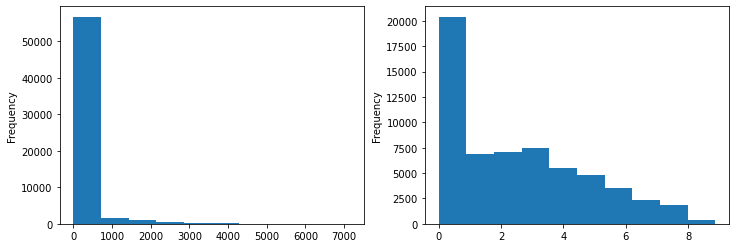

In [3]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_6h_comar['numOfTaxis_area'].plot.hist()

plt.subplot(122)
df_6h_comar['numOfTaxis_area'] = np.log(df_6h_comar['numOfTaxis_area'])
df_6h_comar['numOfTaxis_area'].plot.hist()
plt.show()

In [4]:
df_6h_comar.drop(columns = ['date_start'],inplace = True)
df_6h_hexlow.drop(columns = ['date_start'],inplace = True)
df_6h_hexmed.drop(columns = ['date_start'],inplace = True)
df_6h_hexhig.drop(columns = ['date_start'],inplace = True)

In [5]:
df_6h_comar = pred.dayandseas_to_int(df_6h_comar)
df_6h_hexlow = pred.dayandseas_to_int(df_6h_hexlow)
df_6h_hexmed = pred.dayandseas_to_int(df_6h_hexmed)
df_6h_hexhig = pred.dayandseas_to_int(df_6h_hexhig)

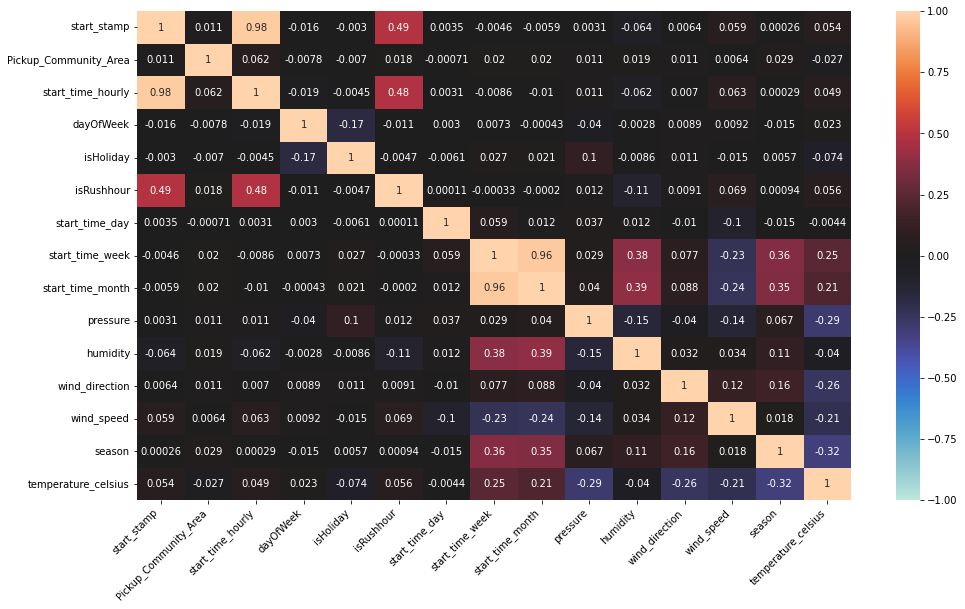

In [6]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_6h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. Also we observe a high correlation between `start_time_hourly` and `start_stamp`. So we are dropping `start_time_hourly`, because we are interested in the 6-hourly interval (which start is represented by `start_stamp`):

In [7]:
df_6h_comar.drop(columns = ['start_time_month'],inplace = True)

In [ ]:
df_6h_comar.drop(columns = ['start_time_hourly'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [ ]:
df_6h_comar.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_6h_hexmed.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_6h_hexhig.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## 2 Hourly Demand - Community Area

In [9]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_comar,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [10]:
categoric, numeric = pred.cat_and_num('Pickup_Community_Area')

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [11]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000)

In [12]:
pipeline = pred.pipeline_fit_predict(svr_lin, categoric, numeric, x_train, y_train, x_val, y_val,
                               df_6h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM]......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*....................................................................................................................................................................................................................................................................................................................................................................................................................................*....................................................................................

#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [13]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000)

In [14]:
pipeline = pred.pipeline_fit_predict(svr_poly2, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_6h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM]........................................................................*........................................*.*
optimization finished, #iter = 112797
obj = -14335.636617, rho = -1.494876
nSV = 32757, nBSV = 29110
MODEL SCORES:
MAE:  29.653
MSE:  13358.024
RMSE:  115.577
Accuracy: 86.49 %
R2:  95.834 %
Max Residual Error:  2375.624


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [15]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000)

In [16]:
pipeline = pred.pipeline_fit_predict(svr_poly3, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_6h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].............................................................*..............................*...........*
optimization finished, #iter = 102342
obj = -17263.352688, rho = -1.604827
nSV = 33877, nBSV = 24460
MODEL SCORES:
MAE:  45.800
MSE:  35588.838
RMSE:  188.650
Accuracy: 84.78 %
R2:  94.857 %
Max Residual Error:  3529.979


#### SVR KERNEL: RBF

In [17]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000)

In [18]:
pipeline = pred.pipeline_fit_predict(svr_rbf, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_6h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].......................................*...............*
optimization finished, #iter = 54119
obj = -15471.473271, rho = -1.190392
nSV = 33838, nBSV = 26758
MODEL SCORES:
MAE:  46.170
MSE:  35759.294
RMSE:  189.101
Accuracy: 84.91 %
R2:  94.953 %
Max Residual Error:  3027.812


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

#### Sampling data for tuning:

In [24]:
x_val, y_val = pred.sampling_already_splitted(x_val, y_val, 'numOfTaxis_area', 5000)

In [29]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),        
                'model__epsilon':loguniform(1e-1, 1e2),  
                'model__coef0':loguniform(1e0, 1e6),    
                'model__gamma':loguniform(1e-2, 1e1)   
                }              

In [30]:
svr_poly2 = SVR(kernel = 'poly',degree = 2,cache_size=15000)

In [31]:
pipeline = pred.pipeline_for_prediction(categoric, numeric, svr_poly2)

In [ ]:
pred.find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749
[CV 1/5; 1/100] END model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749;, score=-2.580 total time=   0.0s
[CV 2/5; 1/100] START model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749
[CV 2/5; 1/100] END model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749;, score=-2.633 total time=   0.0s
[CV 3/5; 1/100] START model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749
[CV 3/5; 1/100] END model__C=1.3292918943162166, mo

In [21]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000,epsilon = 2.610025650613476, C= 45.88156549160973,verbose = 10)

In [22]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                     df_6h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -99358409.231279, rho = -67.651938
nSV = 19266, nBSV = 13922


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  74.799
MSE:  70419.862
RMSE:  265.367
Accuracy: 49.83 %
R2:  68.225 %
Max Residual Error:  5277.985


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon low resolution 

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_hexlow,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_low_res')

In [60]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [61]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                      df_6h_hexlow, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -106216334.908176, rho = -31.404760
nSV = 45998, nBSV = 34352


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  49.649
MSE:  19335.192
RMSE:  139.051
Accuracy: 42.61 %
R2:  59.394 %
Max Residual Error:  1997.387


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon medium resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_hexmed,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_medium_res')

In [72]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [73]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_6h_hexmed, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -71769692.922822, rho = -9.900635
nSV = 53540, nBSV = 36094


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  21.106
MSE:  3232.545
RMSE:  56.855
Accuracy: 34.96 %
R2:  60.551 %
Max Residual Error:  1298.962


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon high resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_hexhig,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_high_res')

In [78]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [79]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_6h_hexhig, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -54172541.831035, rho = -1.700378
nSV = 59016, nBSV = 39918


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.751
MSE:  628.844
RMSE:  25.077
Accuracy: 16.63 %
R2:  45.458 %
Max Residual Error:  599.243
